# SFS: Moran model in an exponentially growing population

#### importación de librerías

In [1]:
import numpy as np
import collections
import pandas as pd
import scipy
from scipy.stats import burr
import scipy.stats
from itertools import filterfalse, repeat
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context='notebook', style="ticks")

#### creación de funciones

In [2]:
def simulaPoblaciones(j, N, gamma, nu):
    """
        Simula la reproducción y la aparición de mutaciones en individuos 
        de una población de tamaño N que ser rigen por el modelo de Moran.
        
        Parámetros
        ----------
        j : int
            Número de individuos con el que inicia la población a simular
        N : int
            Tamaño constante de la población
        gamma : float
            Tasa de nacimiento de individuos
        nu : float 
            Tasa de mutación neutral
        ----------
        
        Tuple[np.array(dtype=object), np.array(dtype=float)]
            Regresa dos arreglos de numpy: 
                el primero contiene listas de enteros (los sitios mutados de cada individuo)
                el segundo contiene floats (la "composición" de la población)
    """ 
    tamanioLim = int(N*gamma)
    p = gamma/(gamma + nu)

    sitiosMut = [[] for _ in range(j)]

    # generamos población inicial aleatoriamente
    individuos = np.sort(np.random.uniform(size = j-1))
    individuos = np.concatenate([[0],individuos,[1]])

    aux = 1
    while j < tamanioLim:
        # cuántas mutaciones van a surgir en total en la población para ese tiempo
        Nj = np.random.geometric(p) 
        # individuos elegidos aleatoriamente que van a tener mutar en el sitio 'aux' 
        s = np.unique(np.random.choice(range(j), size = Nj, replace = True))
        # agregamos el sitio mutado a cada uno de los individuos elegidos
        [sitiosMut[i].append(k) for i,k in zip(s, [aux]*len(s))]

        # nace un nuevo individuo
        newIndiv = np.random.uniform()
        buscaPadre = np.searchsorted(individuos, newIndiv)
        # agregamos el nuevo individuo a la población
        individuos = np.insert(arr=individuos, obj=buscaPadre, values=newIndiv)
        
        # copiamos sitios mutados del padre y agregamos el individuo al arreglo
        indivMutado = deepcopy(sitiosMut[buscaPadre - 1])
        sitiosMut.insert(buscaPadre, indivMutado)

        j += 1
        aux += 1

    sitiosMut = np.asarray(sitiosMut, dtype=object)
        
    return sitiosMut, individuos

In [3]:
def generaMuestra(N, orderStats, tamMuestra):
    """
        Genera una muestra de individuos de la 
        población orderStats de tamaño tamMuestra.
        
        Parámetros
        ----------
        N : int
            Tamaño constante de la población
        orderStats : np.array(dtype=float)
            "Composición" de la población
        tamMuestra : int
            Tamaño de la muestra
        ----------
        
        list(int)
            Regresa una lista de índices
    """
    # generamos muestra aleatoriamente
    setMuestra = np.random.uniform(size = tamMuestra)
    # buscamos índices para saber qué mutaciones les corresponden
    sampleIndices = [np.searchsorted(orderStats, i) for i in setMuestra]
    sampleIndices = [i-1 if i==N else i for i in sampleIndices]
    
    return sampleIndices

In [4]:
def generaSfs(poblacion, tamMuestra=500, orderStats=[], monteCarlo=False, iteraciones=200, histogram=False):
    """
        Genera el SFS de una muestra de tamaño tamMuestra
        proveniente de una población. Se hacen múltiples
        iteaciones y se promedian los resultados para
        aproximar mejor la distribución. 
        
        Parámetros
        ----------
        poblacion : np.array(dtype=object)
            Numpy array cuyas entradas son 
            los sitios mutados de cada individuo
        tamMuestra : int 
            Tamaño de la muestra
        orderStats : np.array(dtype=float)
            "Composición" de la población
        monteCarlo : bool
            Determina si se itera o no
        iteraciones : int
            Número de iteraciones
        histogram:
            Determina el valor de regreso de la función
        ----------
        
        Si histograma==True -> np.array(dtype=int)
            Regresa un arreglo con el sfs
        Else -> list(int)
            Regresa una lista con el sfs explícito
    """
    N = np.shape(poblacion)[0]
    
    if monteCarlo:
        arrIteraciones = np.empty(iteraciones, dtype=object)
        
        # ciclo para obtener un sfs promedio
        for i in range(iteraciones):
            # generamos una muestra distinta cada iteración
            setIndividuos = generaMuestra(N, orderStats, tamMuestra)
            muestra = poblacion[setIndividuos]
            muestra = np.concatenate(muestra).astype(int)
            
            # contamos cuántas mutaciones tiene cada sitio
            cuentaSitios = list(collections.Counter(muestra).values())
            histograma, edges = np.histogram(cuentaSitios, bins=range(1,tamMuestra))
            
            arrIteraciones[i] = histograma
        # promediamos sfs (histogramas)
        sfs = np.mean(arrIteraciones, axis=0)
        
        if not histogram:
            # versión del sfs si se quieren los datos antes de contar frecuencias
            extendedSfs = [list(repeat(b+1, value)) for b, value in enumerate(sfs)]
            extendedSfs = [item for sublist in extendedSfs for item in sublist]
            return extendedSfs
        
        else:
            return sfs
    
    else:
        # mismo razonamiento que en el ciclo for pero sin iteraciones ni promedio
        muestra = np.concatenate(poblacion).astype(int)
        extendedsfs = list(collections.Counter(muestra).values())

        if not histogram:
            return extendedsfs
        else:
            histograma, edges = np.histogram(extendedsfs, bins=range(1,tamMuestra))
            return histograma

In [88]:
def esperanzaDurret(N, tamMuestra, nu, gamma, thrmTwo=False, thrmThree=False):
    """
        Calcula los valores de la esperanza (ecuaciones 2.2 y 2.3 en el trabajo).
        
        Parámetros
        ----------
        N : int
            Tamaño constante de la población
        tamMuestra : int 
            Tamaño de la muestra
        nu : float 
            Tasa de mutación neutral
        gamma : float
            Tasa de nacimiento de individuos
        thrmTwo : bool
            Determina si calcula la esperanza de la ec.2.2
        thrmThree : bool 
            Determina si calcula la esperanza de la ec.2.3
        ----------
        
        Si thrmTwo==True -> np.array(dtype=float)
            Regresa un arreglo con la esperanza de la ec.2.2 para valores en [1,tamMuestra-1]
        Else If thrmTwo==True -> np.array(dtype=float)
            Regresa un arreglo con la esperanza de la ec.2.3 para valores en [1]
        Else -> np.array(dtype=float)
            Regresa un arreglo con la esperanza de la ec.2.2 para valores en [2,tamMuestra-1] 
            y con la esperanza de la ec.2.3 para valores en [1]
    """
    n = tamMuestra
    nNuGamma = (n*nu)/gamma
    nuGamma = nu/gamma
    
    # ec. 2.2
    if thrmTwo:
        # para valores de 2 < m <= n
        nm = [nNuGamma*(1/(u*u-1)) for u in range(2, tamMuestra + 1)] 
        # para m = 1
        nm.insert(0,round(nNuGamma*np.log(N*gamma))) 
        nm = np.asarray(nm)
        return nm
    
    # ec. 2.3
    elif thrmThree:
        # solo para m=1
        sumaNgamma = sum([(n/(n+k))*(k/(n+k-1)) for k in range(1, int(N*gamma) +1)])
        n1 = nuGamma*sumaNgamma
        n1 = np.asarray([n1])
        return n1
    
    # unión de ambas ecuaciones
    else:
        # para valores de 2 < m <= n 
        nm = [nNuGamma*(1/(u*u-1)) for u in range(2, tamMuestra + 1)] 
        # solo para m=1
        sumaNgamma = sum([(n/(n+k))*(k/(n+k-1)) for k in range(1, int(N*gamma) +1)])
        nm.insert(0,nuGamma*sumaNgamma)
        nm = np.asarray(nm)
        return nm    

In [7]:
def generaSubPoblaciones(N, nSubPob, nu, gamma):
    """
        Genera subpoblación de tamaño nSubPob con base en la ec. 2.2
        
        Parámetros
        ----------
        N : int
            Tamaño constante de la población
        nSubPob : int
            Tamaño de la subpoblación
        nu : float 
            Tasa de mutación neutral
        gamma : float
            Tasa de nacimiento de individuos
        ----------
        
        list(float)
            Regresa una lista con los valores del SFS para esa subpoblación
    """
    nNuGamma = (nSubPob*nu)/gamma
    qn = [nNuGamma*(1/(u*u-1)) for u in range(2, nSubPob + 1)] 
    length = len(qn)
    
    if length < n:
        qn.extend([0]*(n-length))
        
    return qn

In [150]:
def muestreoBinomial(tamMuestra, modelo, clonales=500, kPrima=60, **kwargs):
    """
        Calcula el SFS contemplando el muestreo binomial.
        El SFS se calcula a través de la ecuación 2.6 en el trabajo. 

        Parámetros
        ----------
        tamMuestra : int 
            Tamaño de la muestra
        modelo : str 
            Determina qué datos se ocupan para calcular el SFS
        clonales : int
            Número de mutaciones clonales
        kPrima : int
            Número de partes en las que se va a dividir el intervalo (0,1)
        **kwargs : elementos que dependen del modelo
            Posibles valores
                histograma: SFS (general) en formato de histograma
                n1: tamaño de subpoblación del clon 1
                qn0: SFS de la subpoblación del clon 1
                qn1: SFS de la subpoblación del clon 0
                subclonales: número de mutaciones subclonales
        ----------

        list(floats):
            Regresa una lista con el SFS y el muestreo binomial.
    """
    n = tamMuestra
    # dividimos el intervalo en kPrima partes
    intervalDiv = np.linspace(0,1,kPrima)
    intervalSums = np.empty(kPrima, dtype=float)
    # parámetros de la distribución que se ajustó
    params_burr = [7.334946083701974, 0.541092220729855, -0.17832350890702847, 36.37181193451144]
    c,d,loc,scale = params_burr

    # parámetros que se ocupan dependiendo del tipo de modelo
    # caso para las simulaciones y para la esperanza de Durrett
    if modelo == 'clonal':
        histograma = kwargs['histograma']

        lenSfs = np.shape(histograma)[0]
        histograma[lenSfs -1] += clonales
        lower, upper = (0,lenSfs)

    # caso de la ecuación de Kimmel
    elif modelo == 'kimmel':
        subclonales = kwargs['subclonales']
        A = kwargs['A']
        p0 = kwargs['p0']
        p1 = 1-p0

        lower, upper = (2,n+1)

    # caso de subpoblaciones exactas (n0 y n1)
    elif modelo == 'subPob':
        qn0 = kwargs['qn0']
        qn1 = kwargs['qn1']
        subclonales = kwargs['subclonales']
        n1 = kwargs['n1']
        n0 = n - n1

        lower, upper = (1,n)

        for q in [qn0, qn1]:
            q[n - 1] += clonales
            q[n1 - 1] += subclonales 

    print('Progreso: ', end=' ')

    # tres ciclos anidados, basados en la ec. 2.6
    for i in range(kPrima-1):
        # iteramos sobre kPrima intervalos
        xi1 = round(intervalDiv[i], 3)
        xi2 = round(intervalDiv[i+1], 3)

        sumaEta = 0

        # imprime progreso
        if i%10 == 0: print(f'{round((i*10)/6)}%', end=' ')

        for k in range(lower,upper):
            # datos que se sumarán dependiendo del modelo
            if modelo == 'clonal':
                sk = histograma[k]

            elif modelo == 'kimmel':
                sk = (A/(k*(k-1))) + subclonales*scipy.special.comb(n,k)*(p0**(n-k))*(p1**k)
                if k == n: sk += clonales

            elif modelo == 'subPob':
                sk = qn0[k] + qn1[k]

            sumaProbas = 0

            for r in range(1, 101):
                # proba de que la cantidad de reads sea r
                pr = burr.pdf(r,c,d,loc,scale)
                # producto de proba anterior y la f. de distribución binomial
                sumaProbas += pr*(scipy.stats.binom.cdf(xi2*r, r, k/(2*n))
                                  -scipy.stats.binom.cdf(xi1*r, r, k/(2*n))) # la proba por binom

            sumaEta += sumaProbas*sk

        intervalSums[i] = sumaEta

    print('100% \u2714')
    return intervalSums        

#### ajuste de distribución para la variable aleatoria $R$

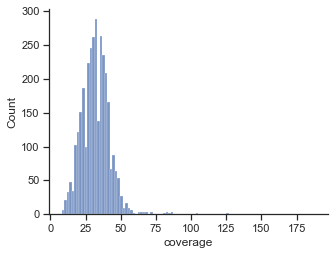

In [2]:
from fitter import Fitter, get_common_distributions, get_distributions
# leemos el archivo
coverage = pd.read_csv('donor_test.csv', sep='\t')
# graficamos distribución
sns.displot(data=coverage, x="coverage", kind="hist", bins = 100, height =3.7, aspect=1.3)

[7.334946083701974, 0.541092220729855, -0.17832350890702847, 36.37181193451144]

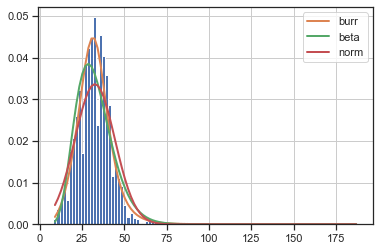

In [4]:
R = coverage["coverage"].values
# probamos ajustar distintas distribuciones
f = Fitter(R, distributions=["burr", "beta", "norm"])
f.fit()
f.summary()
params_burr = [f.fitted_param["burr"][i] for i in range(4)]
params_burr

#### parámetros generales

In [8]:
# parámetros
N = 10000
j = 10
gamma = 1.0
nu = 2.4
n = 200
kPrima = np.linspace(0,1,60)
# para las dos gráficas juntos
vmax=15

#### llamados de funciones (parte 1 - generales):
1. Simulación de la población
2. Generación del SFS de la muestra
3. Cálculo de la esperanza de Durrett para cada bin
    - Cálculo de la esperanza de Durrett para $m=1$

In [147]:
# simulamos la población
sitiosMut,individuos = simulaPoblaciones(j, N, gamma, nu)
print('población simulada: \u2714')
# sfs de la muestra
sfs = generaSfs(poblacion=sitiosMut, orderStats=individuos, tamMuestra=n, monteCarlo=True)
print('SFS generado: \u2714')
# valor esperado de Durrett
expectedVal = esperanzaDurret(N, n, nu, gamma)
# para graficar E[eta_n,1]
expectedValThm2 = esperanzaDurret(N, n, nu, gamma, thrmTwo=True)
evtm2 = expectedValThm2[0]
print('esperanza calculada: \u2714')

población simulada: ✔
SFS generado: ✔
esperanza calculada: ✔


#### llamados de funciones (parte 2 - muestreo binomial):
1. Muestreo binomial para la población simulada (muestra de tamaño $n$)
2. Muestreo binomial para la esperanza de las ecuaciones 2.2 y 2.3
3. Muestreo binomial para la ecuación 2.6 dada por Kimmel
4. Muestreo binomial para las subpoblaciones con tamaños exactos ($n_0$ y $n_1$)


In [151]:
### muestreo binomial para población simulada

# volvimos a generar el sfs pues ahora lo necesitamos en formato de histograma
print('Muestreo Binomial para población simulada.', end=' ')
sfsHist = generaSfs(poblacion=sitiosMut, orderStats=individuos, tamMuestra=n, monteCarlo=True, histogram=True)
binHumpSim = muestreoBinomial(n,'clonal', clonales=200, histograma=sfsHist)

# muestreo binomial para esperanza de Durrett
print('Muestreo Binomial para esperanza de Durrett.', end=' ')
binHumpDurrett = muestreoBinomial(n,'clonal', clonales=50, histograma=expectedVal)

# muestreo binomial para ecuación de Kimmel
print('Muestreo Binomial para ecuación de Kimmel.', end=' ')
binHumpKimmel = muestreoBinomial(n,'kimmel', subclonales=600,A=3000, p0=0.5)

# muestreo binomial para subpoblaciones conocidas
print('Muestreo Binomial para subpoblaciones.', end=' ')
n1=100
qn0=generaSubPoblaciones(N, n-n1, nu, gamma)
qn1=generaSubPoblaciones(N, n1, nu, gamma)
binHumpsubPob = muestreoBinomial(n,'subPob', qn0=qn0, qn1=qn1, n1=n1, clonales=30,subclonales=30)

Muestreo Binomial para población simulada. Progreso:  0% 17% 33% 50% 67% 83% 100% ✔
Muestreo Binomial para esperanza de Durrett. Progreso:  0% 17% 33% 50% 67% 83% 100% ✔
Muestreo Binomial para ecuación de Kimmel. Progreso:  0% 17% 33% 50% 67% 83% 100% ✔
Muestreo Binomial para subpoblaciones. Progreso:  0% 17% 33% 50% 67% 83% 100% ✔


#### gráficas

##### gráfica de sfs de la muestra

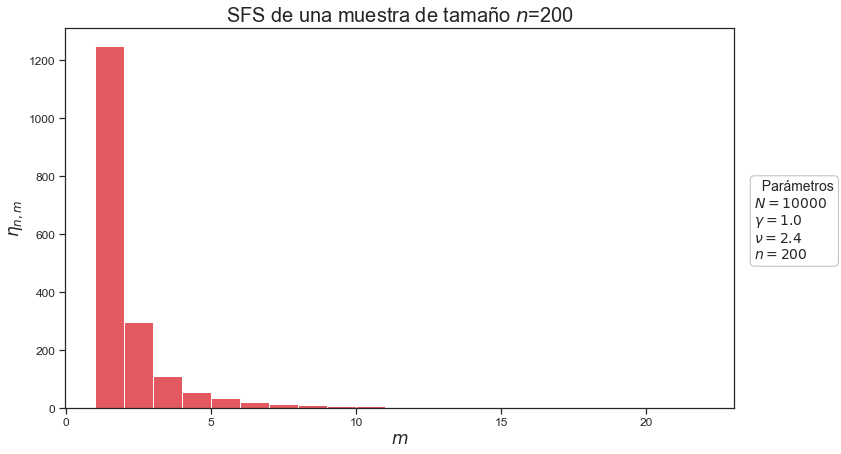

In [11]:
fig, ax = plt.subplots(figsize=(12,7))
# gráfica de sfs
sns.histplot(sfs, binwidth=1.0, color=(219/255, 34/255, 42/255),binrange=(1,22))

# para título, etiquetas de ejes, marcas de ejes, leyenda
ax.set_title(f'SFS de una muestra de tamaño $n$={n}', fontdict={'size': 20})
ax.set_xlabel('$m$', fontdict={'size': 17})
ax.set_ylabel('$\eta_{n,m}$', fontdict={'size': 17})
ax.xaxis.set_tick_params(labelsize = 12)
ax.yaxis.set_tick_params(labelsize = 12)

# para la cajita de parámetros
textstr = '\n'.join(('  Parámetros',
    r'$N=%d$' % (N, ),
    r'$\gamma=%.1f$' % (gamma, ),
    r'$\nu=%.1f$' % (nu, ),
    r'$n=%d$' % (n, )
))
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor=(1.0, 1.0, 1.0), edgecolor='gray', alpha=0.5)
ax.text(1.03, 0.6, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.show()

##### gráfica del valor esperado de Durrett 
Ecuaciones usadas: 

Ecuación 2.2: $\frac{n\nu}{\gamma}\cdot\frac{1}{m(m-1)}, \quad 2 \leq m < n$ 

Ecuación 2.3: $\mathbb{E}[\eta_{n,1}] \approx \frac{\nu}{\gamma}\sum_{k = 1}^{N\gamma} \frac{n}{n + k}\cdot \frac{k}{n + k -1}$ 

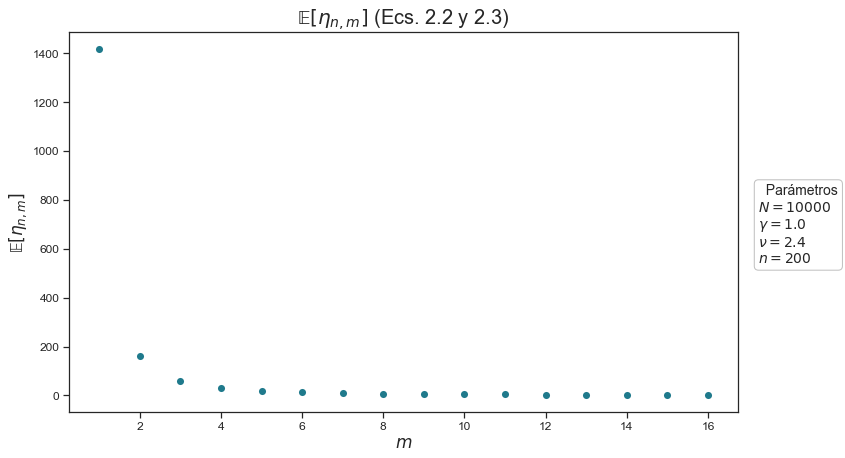

In [89]:
# para el tamaño de la figura y poner propiedades
fig, ax = plt.subplots(figsize=(12,7))
# gráfica de valor esperado
sns.scatterplot(y=expectedVal[:16], x=range(1, 17),  color=(31/255, 122/255, 140/255),s=50, linewidth=0)

# para título, etiquetas de ejes, marcas de ejes, leyenda
ax.set_title('$\mathrm{\mathbb{E}}[\eta_{n,m}]$ (Ecs. 2.2 y 2.3)', fontdict={'size': 20})
ax.set_xlabel('$m$', fontdict={'size': 17})
ax.set_ylabel('$\mathrm{\mathbb{E}}[\eta_{n,m}]$', fontdict={'size': 17})
ax.xaxis.set_tick_params(labelsize = 12)
ax.yaxis.set_tick_params(labelsize = 12)

# para la cajita de parámetros
textstr = '\n'.join(('  Parámetros',
    r'$N=%d$' % (N, ),
    r'$\gamma=%.1f$' % (gamma, ),
    r'$\nu=%.1f$' % (nu, ),
    r'$n=%d$' % (n, )
))
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor=(1.0, 1.0, 1.0), edgecolor='gray', alpha=0.5)
ax.text(1.03, 0.6, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.show()

##### para gráficas juntas de SFS, esperanza de Durrett (ecs. 2.2 y 2.3)

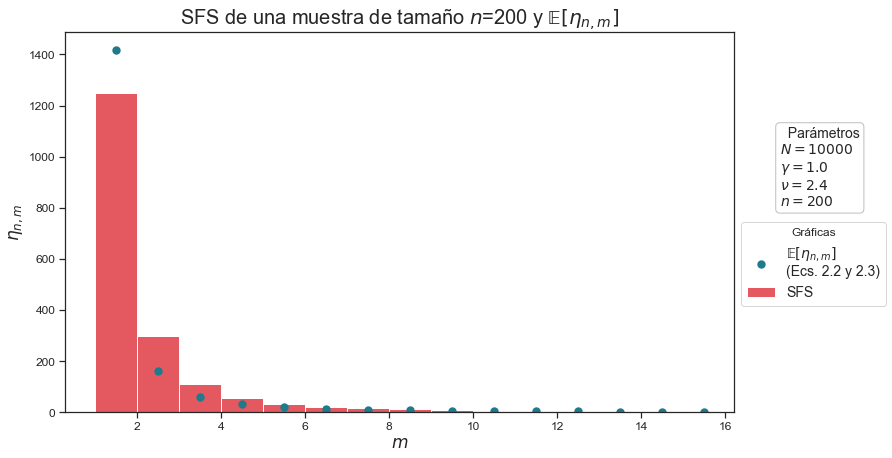

In [143]:
# para el tamaño de la figura y poner propiedades
fig, ax = plt.subplots(figsize=(12,7))

# para graficar (incluye color y nombre de gráfica para leyenda)
sns.histplot(sfs, binwidth=1.0, color=(219/255, 34/255, 42/255), 
             binrange=(1,vmax), label='SFS', ax=ax)
sns.scatterplot(y=expectedVal[:vmax], x=np.linspace(1.5,vmax+0.5,num=vmax), 
                color=(31/255, 122/255, 140/255), label= '$\mathrm{\mathbb{E}}[\eta_{n,m}]$ \n(Ecs. 2.2 y 2.3)', 
                s=70, linewidth=0, ax=ax)

# se usaron para graficar solo la ecuación 2.2
# sns.scatterplot(y=[evtm2], x=[1.5], color=(177/255, 121/255, 140/255),
#                 label= '$\mathrm{\mathbb{E}}[\eta_{n,1}]$ \n(Ec. 2.2, para $m=1$)', s=75,linewidth=0,ax=ax)


# para título, etiquetas de ejes, marcas de ejes, leyenda
ax.set_title(f'SFS de una muestra de tamaño $n$={n} y $\mathrm{{\mathbb{{E}}}}[\eta_{{n,m}}]$', 
             fontdict={'size': 20})
ax.set_xlabel('$m$', fontdict={'size': 17})
ax.set_ylabel('$\eta_{n,m}$', fontdict={'size': 17})
ax.legend(loc='center left', bbox_to_anchor=(1, 0.39),title="Gráficas", fontsize=14)
ax.xaxis.set_tick_params(labelsize = 12)
ax.yaxis.set_tick_params(labelsize = 12)

# para la cajita de parámetros
textstr = '\n'.join(('  Parámetros',
    r'$N=%d$' % (N, ),
    r'$\gamma=%.1f$' % (gamma, ),
    r'$\nu=%.1f$' % (nu, ),
    r'$n=%d$' % (n, )
))
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor=(1.0, 1.0, 1.0), edgecolor='gray', alpha=0.5)
ax.text(1.068, 0.75, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props) # parámetros para cuando se grafican los 3: 1.068, 0.83

plt.show()

##### gráficas de Muestreo binomial

**población simulada**

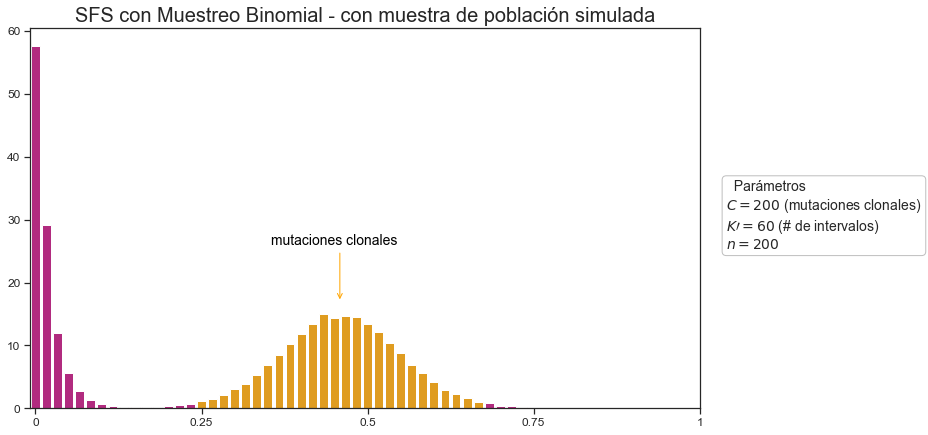

In [137]:
**población simulada**# gráfica del muestreo binomial para población simulada
fig, ax= plt.subplots(figsize=(12,7))   

colors = ['orange' if (x > 0.25 and x < 0.68) else 'mediumvioletred' for x in kPrima]
sns.barplot(x=kPrima[1:-1], y=binHumpSim[1:-1], palette=colors)
ax.set_xticks([0.0, 15, 30, 45, 60], ['0','0.25', '0.5', '0.75','1'])

# para título, etiquetas de ejes, marcas de ejes, leyenda
ax.set_title(f'SFS con Muestreo Binomial - con muestra de población simulada', 
             fontdict={'size': 20})
ax.xaxis.set_tick_params(labelsize = 12)
ax.yaxis.set_tick_params(labelsize = 12)

# para la cajita de parámetros
textstr = '\n'.join(('  Parámetros',
    r'$C=%d$ (mutaciones clonales)' % (clonales, ),
    r'$K\prime=%d$ (# de intervalos)' % (np.shape(kPrima)[0], ),
    r'$n=%d$' % (n, ),
))
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor=(1.0, 1.0, 1.0), edgecolor='gray', alpha=0.5)
ax.text(1.04, 0.6, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

# para señalar mutaciones clonales
props1 = dict(boxstyle='round', facecolor=(1.0, 1.0, 1.0), alpha=0.5)
textstr1 = 'mutaciones clonales'
ax.text(0.36, 0.46, textstr1, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', color='black',bbox=props1)
ax.annotate("", xy=(27.5, 17), xytext=(27.5, 25),
            arrowprops=dict(arrowstyle="->", color='orange'))

plt.show()

**esperanza Durrett**

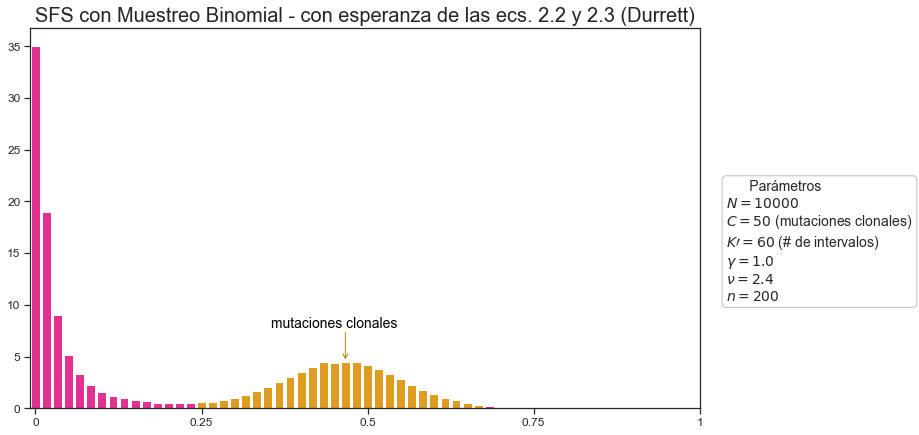

In [120]:
clonales = 50
# gráfica del muestreo binomial para población simulada
fig, ax= plt.subplots(figsize=(12,7))   

colors = ['orange' if (x > 0.25 and x < 0.68) else 'deeppink' for x in kPrima] 
sns.barplot(x=kPrima[1:-1], y=binHumpDurrett[1:-1], palette=colors)
ax.set_xticks([0.0, 15, 30, 45, 60], ['0','0.25', '0.5', '0.75','1'])

# para título, etiquetas de ejes, marcas de ejes, leyenda
ax.set_title(f'SFS con Muestreo Binomial - con esperanza de las ecs. 2.2 y 2.3 (Durrett)', 
             fontdict={'size': 20})
ax.xaxis.set_tick_params(labelsize = 12)
ax.yaxis.set_tick_params(labelsize = 12)

# para la cajita de parámetros
textstr = '\n'.join(('      Parámetros',
    r'$N=%d$' % (N, ),
    r'$C=%d$ (mutaciones clonales)' % (clonales, ),
    r'$K\prime=%d$ (# de intervalos)' % (np.shape(kPrima)[0], ),
    r'$\gamma=%.1f$' % (gamma, ),
    r'$\nu=%.1f$' % (nu, ),
    r'$n=%d$' % (n, )
))
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor=(1.0, 1.0, 1.0), edgecolor='gray', alpha=0.5)
ax.text(1.04, 0.6, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

# para señalar mutaciones clonales
textstr1 = 'mutaciones clonales'
props1 = dict(boxstyle='round', facecolor=(1.0, 1.0, 1.0), alpha=0.5)
ax.text(0.36, 0.24, textstr1, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', color='black',bbox=props1)
ax.annotate("", xy=(28, 4.5), xytext=(28, 7.5),
            arrowprops=dict(arrowstyle="->", color='darkgoldenrod'))

plt.show()

**ecuación de Kimmel**

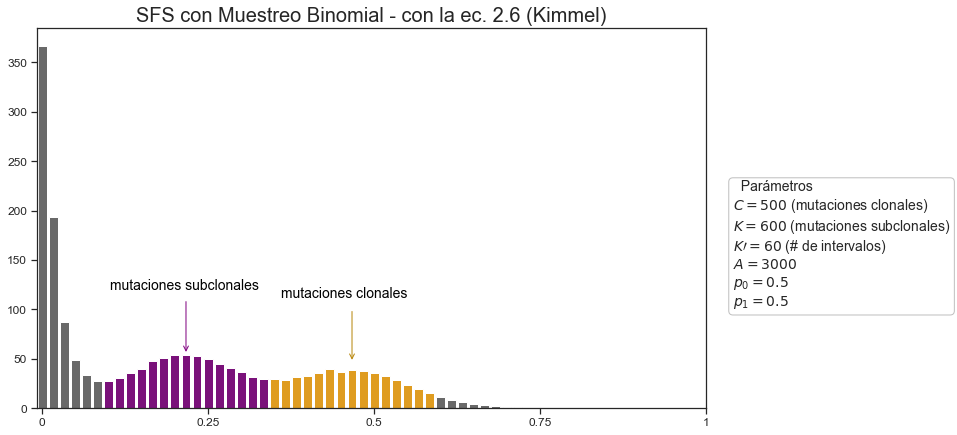

In [75]:
clonales = 500
subclonales = 600
A = 3000
p0 = 0.5
p1 = 1 - p0
# gráfica del muestreo binomial para población simulada
fig, ax= plt.subplots(figsize=(12,7))   
#purple if darkmagenta doesn't work
colors = ['darkmagenta' if (x > 0.1 and x < 0.34) else 'orange' if (x > 0.35 and x < 0.6) else 'dimgray' for x in kPrima] 
sns.barplot(x=kPrima[1:], y=binHumpKimmel[1:], palette=colors)
ax.set_xticks([0.0, 15, 30, 45, 60], ['0','0.25', '0.5', '0.75','1'])

# para título, etiquetas de ejes, marcas de ejes, leyenda
ax.set_title(f'SFS con Muestreo Binomial - con la ec. 2.6 (Kimmel)', 
             fontdict={'size': 20})
ax.xaxis.set_tick_params(labelsize = 12)
ax.yaxis.set_tick_params(labelsize = 12)

# para la cajita de parámetros
textstr = '\n'.join(('  Parámetros',
    r'$C=%d$ (mutaciones clonales)' % (clonales, ),
    r'$K=%d$ (mutaciones subclonales)' % (subclonales, ),
    r'$K\prime=%d$ (# de intervalos)' % (np.shape(kPrima)[0], ),
    r'$A=%d$' % (A, ),
    r'$p_0=%.1f$' % (p0, ),
    r'$p_1=%.1f$' % (p1, )
))
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor=(1.0, 1.0, 1.0), edgecolor='gray', alpha=0.5)
ax.text(1.04, 0.6, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

# para señalar mutaciones clonales
textstr1 = 'mutaciones clonales'
props1 = dict(boxstyle='round', facecolor=(1.0, 1.0, 1.0), alpha=0.5)
ax.text(0.365, 0.32, textstr1, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', color='black',bbox=props1)
ax.annotate("", xy=(28, 47), xytext=(28, 100),
            arrowprops=dict(arrowstyle="->", color='darkgoldenrod'))

# para señalar mutaciones subclonales
textstr2 = 'mutaciones subclonales'
props2 = dict(boxstyle='round', facecolor=(1.0, 1.0, 1.0), alpha=0.5)
ax.text(0.11, 0.34, textstr2, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', color='black',bbox=props2)
ax.annotate("", xy=(13, 55), xytext=(13, 110),
            arrowprops=dict(arrowstyle="->", color='purple'))

plt.show()

**subpoblaciones con tamaños exactos**

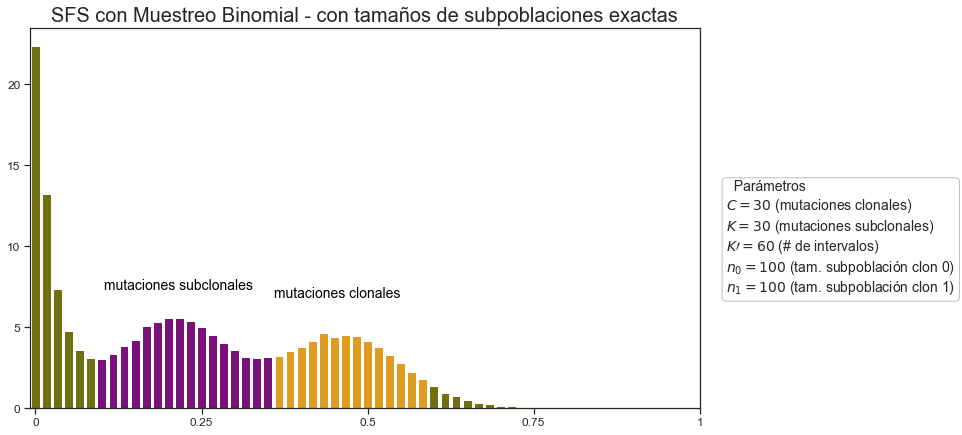

In [83]:
clonales=30
subclonales=30
fig, ax= plt.subplots(figsize=(12,7))   
#purple if darkmagenta doesn't work
colors = ['darkmagenta' if (x > 0.1 and x < 0.36) else 'orange' if (x > 0.36 and x < 0.6) else 'olive' for x in kPrima] 
sns.barplot(x=kPrima[1:-1], y=binHumpsubPob[1:-1], palette=colors)
ax.set_xticks([0.0, 15, 30, 45, 60], ['0','0.25', '0.5', '0.75','1'])

# para título, etiquetas de ejes, marcas de ejes, leyenda
ax.set_title(f'SFS con Muestreo Binomial - con tamaños de subpoblaciones exactas', 
             fontdict={'size': 20})
ax.xaxis.set_tick_params(labelsize = 12)
ax.yaxis.set_tick_params(labelsize = 12)

# para la cajita de parámetros
textstr = '\n'.join(('  Parámetros',
    r'$C=%d$ (mutaciones clonales)' % (clonales, ),
    r'$K=%d$ (mutaciones subclonales)' % (subclonales, ),
    r'$K\prime=%d$ (# de intervalos)' % (np.shape(kPrima)[0], ),
    r'$n_0=%d$ (tam. subpoblación clon 0)' % (n-n1, ),
    r'$n_1=%d$ (tam. subpoblación clon 1)' % (n1, )
))
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor=(1.0, 1.0, 1.0), edgecolor='gray', alpha=0.5)
ax.text(1.04, 0.6, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

# para señalar mutaciones clonales
textstr1 = 'mutaciones clonales'
props1 = dict(boxstyle='round', facecolor=(1.0, 1.0, 1.0), alpha=0.5)
ax.text(0.365, 0.32, textstr1, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', color='black',bbox=props1)
ax.annotate("", xy=(28, 47), xytext=(28, 100),**ecuación de Kimmel**
            arrowprops=dict(arrowstyle="->", color='darkgoldenrod'))

# para señalar mutaciones subclonales
textstr2 = 'mutaciones subclonales'
props2 = dict(boxstyle='round', facecolor=(1.0, 1.0, 1.0), alpha=0.5)
ax.text(0.11, 0.34, textstr2, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', color='black',bbox=props2)
ax.annotate("", xy=(13, 55), xytext=(13, 110),
            arrowprops=dict(arrowstyle="->", color='purple'))

plt.show()